### Goal: Implementing K-Means clustering and PCA (Principal Component Analysis) from scratch with numpy. 

In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.stats import gmean
%matplotlib inline

### Load Data

Load train and test data for the Fashion MNIST dataset using PyTorch.

In [2]:
data_dimension  = 28*28     # images are 28x28 pixels
num_classes = 10            # there are 10 classes

train_dataset = datasets.FashionMNIST(
    root="data_fashion",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

# Download test data from open datasets.
test_dataset = datasets.FashionMNIST(
    root="data_fashion",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 14.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.48MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 5.14MB/s]


### Subsample Creation

Subsample the train and test set such both contain 1000 images, with 100 images from each of the 10 classes. Also store the labels for each image.

In [3]:
images_per_class = 100

# Create a new dataset with only 100 images per class and with a total of 1000 images
def create_subset(dataset, images_per_class):
    """
    Create a dataset with only a given number of images per class.

    Args:
        dataset: The original dataset
        images_per_class: The number of images per class to keep
    
    Returns:
        images: A numpy array of shape (num_classes * images_per_class, data_dimension) (10, 100,  28*28)
        labels: A numpy array of shape (num_classes * images_per_class,) (10, 100)
    """
    images, labels = [], []
    
    # flatten -> ndarray -> append
    c = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
    for x,y in dataset:
        if c[y] != 0:
            x = np.array(np.squeeze(torch.flatten(x, start_dim = 1)))
            images.append(x)
            labels.append(y)
            c[y] -= 1
            
    
    return np.array(images), np.array(labels) # (1000, 784) (1000, 1)

# Train and test data
train_images, train_labels = create_subset(train_dataset, images_per_class)
test_images, test_labels = create_subset(test_dataset, images_per_class)
train_counter = Counter(train_labels)
test_counter = Counter(test_labels)

C:\Users\oasis\AppData\Local\Temp\ipykernel_32016\3363834259.py:22: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  x = np.array(np.squeeze(torch.flatten(x, start_dim = 1)))


### Principal Component Analysis (PCA)

Perform principal component analysis (PCA) on the train dataset to reduce the data dimension from `784` to `100`.

In [8]:
def PCA(X , num_components):
    """
    Function to perform PCA on the dataset X.

    Args:
        X: A numpy array of shape (num_samples, data_dimension)
        num_components: The number of principal components to keep

    Returns:
        X_reduced: A numpy array of shape (num_samples, num_components). The represents the reduced data.
        X_reconstructed: A numpy array of shape (num_samples, data_dimension). The represents the reconstructed data from the reduced data.
    """
     # standardize data, keeps the mean and var for later inversion
    scaler = StandardScaler()
    scaler.fit(X)
    data = scaler.transform(X)
    
    # compute covariance matrix c
    c = np.cov(data.T) # 784, 784
    
    # compute eigan vectors and eiganvalues of c
    eiganvalue, eiganvector = np.linalg.eig(c) #784, (784, 784)
    eiganvector = eiganvector.T

    # sort the eigan vectors according ot kth eigan value = kth PC
    idx = eiganvalue.argsort()[::-1]
    eiganvalue = eiganvalue[idx]
    eiganvector = eiganvector[:,idx]
    
    # construct projection matrix W with dimen (d by k) = (784 by 100)
    subset = eiganvector[:num_components] # (100, 784)
    
    # transform
    
    # reduc = data * subset.T
    X_reduced = np.dot(data, subset.T) # (1000, 784) (784, 100) = (1000, 100)
    
    # data = subset * reduc = (1000, 100) (100, 784) = (1000, 784)
    # data -> inverse transform from standard scaler
    X_reconstructed = scaler.inverse_transform(np.dot(X_reduced, subset))
    return X_reduced, X_reconstructed


In [9]:
pca_dimension = 100
train_images_pca, reconstruction = PCA(train_images, pca_dimension)


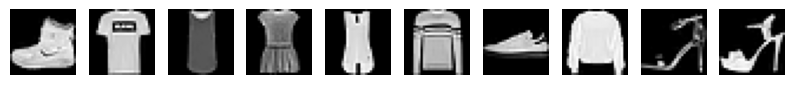

In [10]:
# Visualize the original images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')

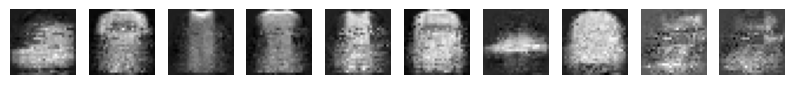

In [11]:
# Visualize the reconstructed images
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(reconstruction[i].reshape(28, 28), cmap='gray')
    plt.axis('off')


The reconstructed images look similar to the original, as they should. 

### KMeans Clustering

Clustering the train images that had been reduced to 100 dimensions using PCA into `10 clusters`.

In [ ]:
def distance(v1, v2):
    """
    euclidean distance between 2 vectors
    """
    return np.sqrt(np.sum((v1 - v2)**2))

def euclidean(point, data):
    """
    Euclidean distance between point & data.
    Point has dimensions (m,), data has dimensions (n,m), and output will be of size (n,).

    Args:
        point: A numpy array of shape (m,)
        data: A numpy array of shape (n,m)

    Returns:
        A numpy array of shape (n,) containing the euclidean distance between point and each row of data.
    """
    dist = []
    # calc distance between point and all other vectors (observations)
    for i in range(len(data)):
        dist.append(distance(point, data[i]))
    return dist

class KMeans:
    """
    Class to perform K-Means clustering.
    """
    def __init__(self, n_clusters=8, max_iter=300):
        """
        Args:
            n_clusters: The number of clusters
            max_iter: The maximum number of iterations to run the algorithm for
        
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        
    def init_centroids(self, X):
        """
        Initialize the centroids by randomly sampling from the dataset. Store the computed
        centroids in self.centroids.

        Args:
            X: A numpy array of shape (num_samples, data_dimension)
        
        Hint: Initialize the centroids such that when a random datapoint is selected as the first, 
              the rest are initialized w/ probabilities proportional to their distances to the first.
              You may use argument `p` in np.random.choice to do this.
        """
        # input X is the entire (1000, 100) dataset
        # initilize centroids such that when c1 is chosen, c2-ck are initialized with probabilities proportaionl to distance from first.
        centroids = []
        first = np.random.choice(len(X))
        centroids.append(X[first])
        d = euclidean(X[first], X)
        d = d/sum(d)
        for i in range(1, self.n_clusters):
            centroids.append(np.random.choice(len(X), p = d))
        self.centroids = centroids #[c1, c2, ..., ck]

    def fit(self, X_train):
        """
        Train the K-Means model on the dataset X_train.

        Args:
            X_train: A numpy array of shape (num_samples, data_dimension) (1000, 100)

        Hint: 
            (1) Use the euclidean function defined above. 
            (2) Run the algorithm for a maximum of self.max_iter iterations.
            (3) Initialize the centroids before running the clustering algorithm.
        """
        # Before clustering algorithm: Initialize centroids
        self.init_centroids(X_train)

        # for each training iteration
        # for each point
        # get distance to all centroids -> find closest -> label
        # update each centroid according to geo_mean of each cluster
        self.pred = [] # corresponding X_train
        for run in range(self.max_iter):
            labels = [[]*self.n_clusters] 
            for point in range(len(X_train)):
                d = euclidean(X_train[point], self.centroids)
                cluster = d.index(min(d))
                labels[cluster].append(X_train[point])
                self.pred.append(cluster)
                
            # update centroid according to average of each feature
            new_centroids = []
            for cluster in labels:
                new_single = []
                cluster = np.array(cluster).T
                new_single.append([np.mean(x) for x in cluster])
                new_centroids.append(new_single)
            self.centroids = new_centroids
        
            
    def evaluate(self, X):
        """
        Function to evaluate the K-Means model on the dataset X.

        Args:
            X: A numpy array of shape (num_samples, data_dimension)
        
        Returns:
            centroids: A numpy array of shape (n_clusters, data_dimension) containing the centroids of the clusters.
            centroid_idxs: A numpy array of shape (num_samples,) containing the cluster labels for each sample in X.
        """
        self.fit(X)
        # already set self.attr in self.fit()
        return self.centroids, self.pred # (cluster_idx, dimensions of cluster)

In [13]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(train_images_pca)

# View results
class_centers, classification = kmeans.evaluate(train_images_pca)

### Plot mean image for each cluster

The KMeans clustering algorithm provides us with 10 clusters, with each cluster containing a set of images. 

Compute the mean image for each cluster and plot it as a grid with 10 images such that each image corresponds to the mean image of a cluster. 

Mean image of a cluster, is the mean of the images contained in the cluster.

In [14]:
# Plot grid of cluster images from each class (as plot each centroid)
centroids, pred = kmeans.evaluate(train_images_pca)
centroids = torch.from_numpy(np.array(centroids)) 
print(centroids[0].shape) # each centroid is of size (1, 100)

grid = torchvision.utils.make_grid(centroids, nrow=10)
grid = torchvision.transforms.ToPILImage()(grid)
grid.show()


torch.Size([1, 100])
